In [2]:
import pandas as pd

clusters = pd.read_csv('../cluster_means.csv')
clusters

,Cluster,b_maj,b_min,b_pa,amount
0,0,37.3,12.10,17.10,3683.0
1,1,14.6,6.63,14.40,14838.0
2,2,15.9,8.64,72.10,3103.0
3,3,14.6,7.93,-74.20,2456.0
4,4,15.1,7.40,37.20,5244.0
5,5,14.5,7.26,-40.80,4175.0
6,6,36.9,11.80,-13.10,7992.0
7,7,14.1,6.21,-15.50,16770.0
8,8,21.8,8.46,-3.27,14712.0
9,9,11.9,5.40,-2.21,49254.0


In [3]:
import numpy as np
from matplotlib.image import imsave
from scipy.signal import unit_impulse
from astropy.convolution import convolve_fft
from skimage.draw import line


def sqr(x: float) -> float: return x * x

class Beams(object):
    rgb = 255
    def __init__(self, shape: tuple = (512, 512)) -> None:
        self.shape = shape
        self.kernels = None
    
    def point_beam(self, point: tuple = (0, 0), max_int: int = None) -> np.array:
        if max_int is None:
            max_int = self.rgb
        coords = (point[0] + self.shape[0]//2, point[1] + self.shape[1]//2)
        return unit_impulse(self.shape, coords) * max_int
    
    def two_points_beam(
            self, d: int, alpha: float, point: tuple = (0, 0), max_int: int = None
        ) -> np.array:
        x0, y0 = point
        point2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        two_points = self.point_beam(point) + self.point_beam(point2, max_int=max_int)
        return two_points / np.max(two_points) * self.rgb
    
    def gauss_beam(
            self, b_maj: int, b_min: int, b_pa: float, 
            shape: tuple = None, point: tuple = (0, 0),
            max_int: int = None, degrees: bool = False
        ) -> np.array:
        if shape is None: shape = self.shape
        if max_int is None: max_int = self.rgb
        if degrees: b_pa = np.deg2rad(b_pa)

        x0, y0 = point
        a = (sqr(np.cos(b_pa)) / (2 * sqr(b_maj)) + 
             sqr(np.sin(b_pa)) / (2 * sqr(b_min)))
        b = (-np.sin(2 * b_pa) / (4 * sqr(b_maj)) + 
             np.sin(2 * b_pa) / (4 * sqr(b_min)))
        c = (sqr(np.sin(b_pa)) / (2 * sqr(b_maj)) + 
             sqr(np.cos(b_pa)) / (2 * sqr(b_min)))
        x, y = np.meshgrid(np.linspace(-shape[0]//2, shape[0]//2-1, shape[0]), 
                           np.linspace(-shape[1]//2, shape[1]//2-1, shape[1]))
        e = np.exp(-(a * sqr(x-x0) + 2 * b * (x-x0) * (y-y0) + c * sqr(y-y0)))
        return e * max_int
    
    def _point_beam(self, point: tuple = (0, 0)) -> np.array:
        return self.gauss_beam(1, 1, 0, point=point)

    def two_gauss_beam(
            self, b_maj1: int, b_min1: int, b_pa1: float, 
            b_maj2: int, b_min2: int, b_pa2: float,
            d: int, alpha: float, point: tuple = (0, 0), 
            max_int: int = None
        ) -> np.array:
        x0, y0 = point
        point2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        gauss1 = self.gauss_beam(b_maj1, b_min1, b_pa1, point=point)
        gauss2 = self.gauss_beam(b_maj2, b_min2, b_pa2, point=point2, max_int=max_int)
        two_gauss = gauss1 + gauss2
        return two_gauss / np.max(two_gauss) * self.rgb
    
    def _two_points_beam(
            self, d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        return self.two_gauss_beam(1, 1, 0, 1, 1, 0, d, alpha, point=point)
    
    def gauss_w_jet_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss_w_jet = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        jet = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        rr, cc = line(x0, y0, jet[0], jet[1])
        gauss_w_jet[rr, cc] = self.rgb
        return gauss_w_jet
    
    def gauss_w_two_jets_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss_w_jets = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        jet1 = (int(x0 - d * np.sin(alpha)), int(y0 - d * np.cos(alpha)))
        jet2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        rr, cc = line(jet1[0], jet1[1], jet2[0], jet2[1])
        gauss_w_jets[rr, cc] = self.rgb
        return gauss_w_jets
    
    def gauss_w_spiral_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            v: float, c: float, w: float, phi: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        t = np.linspace(0, self.shape[0]//8-1, self.rgb)
        x = np.array((v * t + c) * np.cos(w * t + phi) + x0).astype(int)
        y = np.array((v * t + c) * np.sin(w * t + phi) + y0).astype(int)
        gauss[x, y] = self.rgb
        return gauss

    def draw_beam(self, beam: np.array, filename: str, path: str = None) -> None:
        if path is None: path = '..'
        imsave(f'{path}/{filename}.png', np.log10(beam + 1), origin='lower')
    
    def conv(self, model: np.array, kernel: np.array) -> np.array:
        c = convolve_fft(model, kernel)
        return c / np.max(c) * self.rgb
    
    def kernel(
            self, b_maj: int, b_min: int, b_pa: float,
            shape: tuple = None, point: tuple = (0, 0)
        ) -> np.array:
        if shape is None:
            shape = (self.shape[0]//8, self.shape[1]//8)
        return self.gauss_beam(
            b_maj, b_min, b_pa,
            shape=shape, point=point, degrees=True
        )
    
    def get_kernels(self, cluster_means: pd.DataFrame) -> list:
        if self.kernels is not None:
            return self.kernels
        rows = cluster_means.shape[0]
        alpha, ratio = np.sqrt(np.log10(2)), 6 # wtf is this 
        self.kernels = []
        for row in range(rows):
            datum = cluster_means.loc[row].to_list()[1:4]
            sigma = max(datum[0], datum[1]) / alpha
            sh = np.ceil(ratio * sigma).astype(int)
            kernel_size = (sh, sh)
            k = self.kernel(*datum, shape=kernel_size)
            self.kernels.append(k)
        return self.kernels
    
    def draw_kernels(self, cluster_means: pd.DataFrame) -> None:
        kernels = self.get_kernels(cluster_means)
        for ind, kernel in enumerate(kernels):
            self.draw_beam(kernel, f'kernel_{ind}')

In [4]:
def k_size(cluster_means: pd.DataFrame, ind: int) -> tuple:
    alpha, ratio = np.sqrt(np.log10(2)), 6
    datum = cluster_means.loc[ind].to_list()[1:4]
    sigma = max(datum[0], datum[1]) / alpha
    sh = np.ceil(ratio * sigma).astype(int)
    return (sh, sh)

In [5]:
# from numpy import deg2rad

# b = Beams()
# point = b.gauss_w_jet_beam(5, 3, deg2rad(-45), 50, deg2rad(-50))
# # kern = b.kernel(14.6, 6.63, 14.40, shape=k_size(clusters, 1))
# kern = b.kernel(15.9, 8.64, 72.10, shape=k_size(clusters, 2))
# # kern = b.kernel(14.6, 7.93, -74.20, shape=k_size(clusters, 3))
# c = b.conv(point, kern)
# b.draw_beam(c, 'test')
# # b.draw_kernels(clusters)

In [6]:
def crop(im):
    return im[im.shape[0]//4:3 * im.shape[0]//4, im.shape[1]//4:3 * im.shape[1]//4]

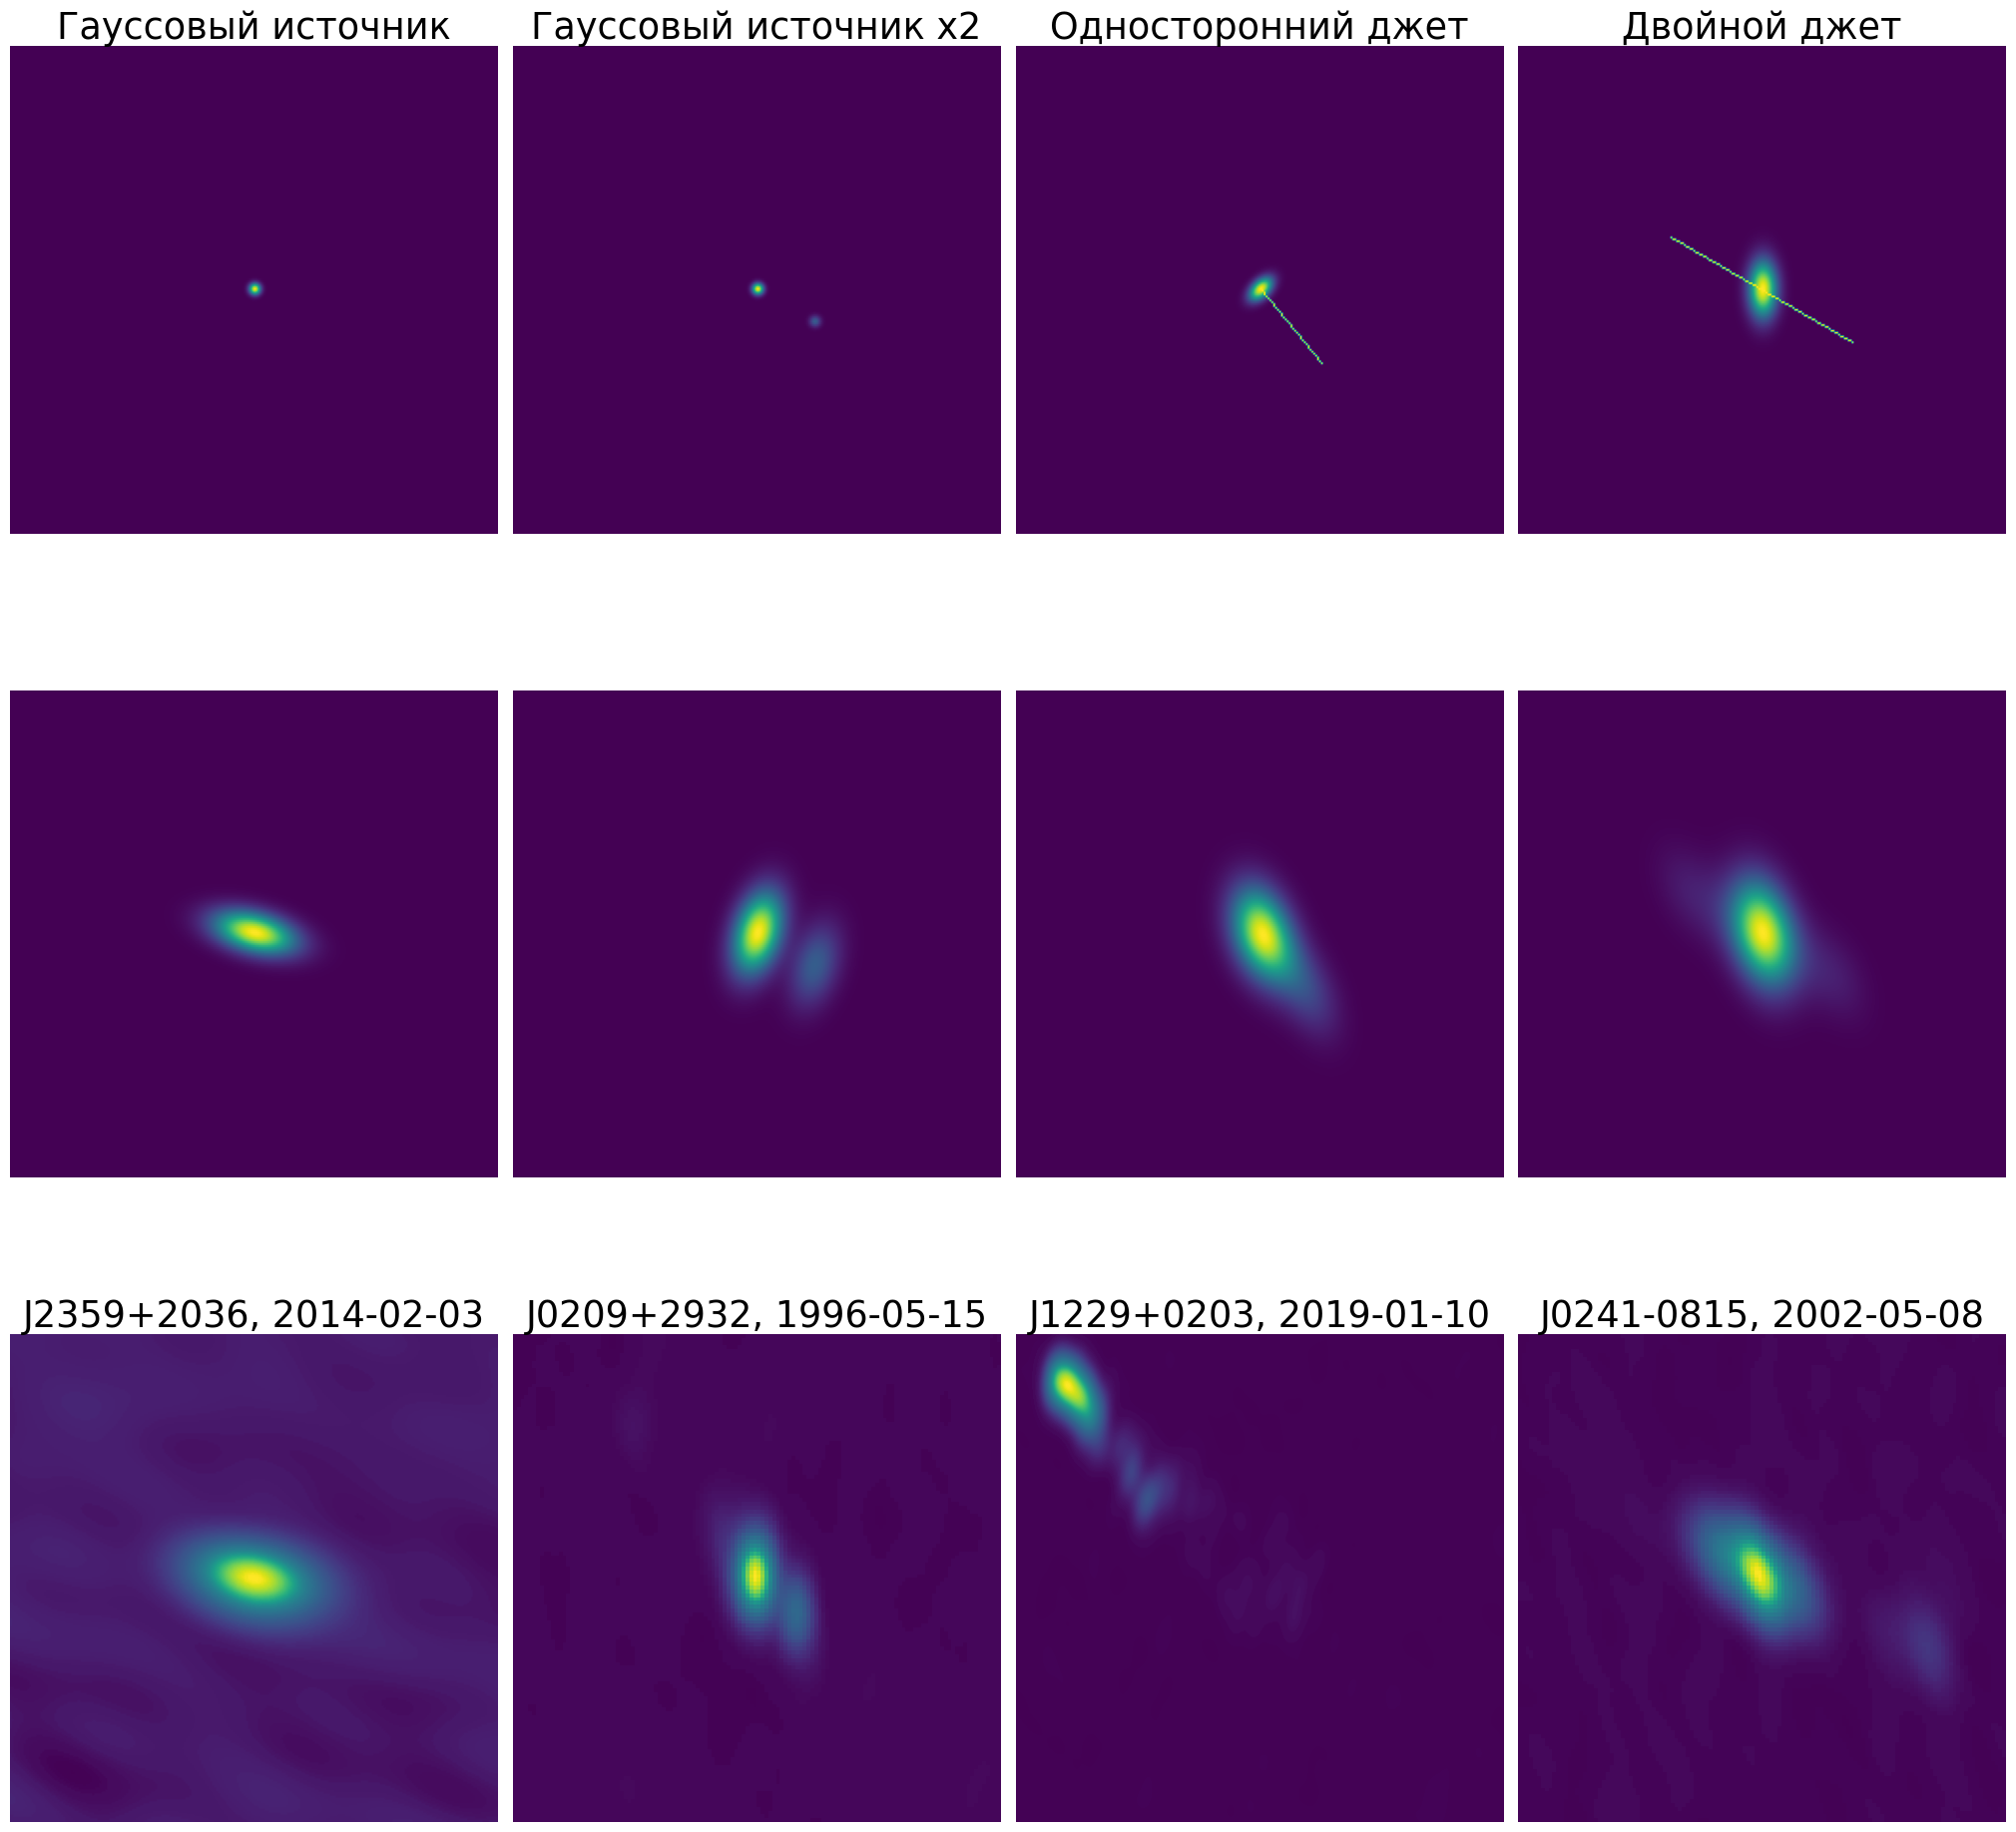

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import deg2rad

b = Beams()
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
kern1 = b.kernel(14.6, 6.63, 14.40, shape=k_size(clusters, 1))
kern2 = b.kernel(15.9, 8.64, 72.10, shape=k_size(clusters, 2))
kern3 = b.kernel(14.6, 7.93, -74.20, shape=k_size(clusters, 3))

one_point = b.gauss_beam(2, 2, 0)
one_point = crop(one_point)
axes[0][0].imshow(one_point, origin='lower')
axes[0][0].axis('off')
axes[0][0].set_title('Гауссовый источник')

axes[1][0].imshow(b.conv(one_point, kern1), origin='lower')
axes[1][0].axis('off')
# axes[1][0].set_title('Гауссовый источник после свёртки')

two_points = b.two_gauss_beam(2, 2, 0, 2, 2, 0, 35, deg2rad(120), max_int=75)
two_points = crop(two_points)
axes[0][1].imshow(two_points, origin='lower')
axes[0][1].axis('off')
axes[0][1].set_title('Гауссовый источник x2')

axes[1][1].imshow(b.conv(two_points, kern3), origin='lower')
axes[1][1].axis('off')
# axes[1][1].set_title('Гауссовый источник x2 после свёртки')

jet = b.gauss_w_jet_beam(5, 3, deg2rad(-45), 50, deg2rad(-50))
jet = crop(jet)
axes[0][2].imshow(jet, origin='lower')
axes[0][2].axis('off')
axes[0][2].set_title('Односторонний джет')

axes[1][2].imshow(b.conv(jet, kern2), origin='lower')
axes[1][2].axis('off')
# axes[1][2].set_title('Гауссовый источник с джетом\nпосле свёртки')

two_jets = b.gauss_w_two_jets_beam(10, 5, deg2rad(90), 55, deg2rad(-30))
two_jets = crop(two_jets)
axes[0][3].imshow(two_jets, origin='lower')
axes[0][3].axis('off')
axes[0][3].set_title('Двойной джет')

axes[1][3].imshow(b.conv(two_jets, kern2), origin='lower')
axes[1][3].axis('off')
# axes[1][3].set_title('Гауссовый источник с двойным джетом\nпосле свёртки')
# axes[0].set_title('test')
container_path = '../data'
real_sources = ['J2359+2036_C_2014_02_03_pet_map.png', 'J0209+2932_S_1996_05_15_yyk_map.png',
                'J1229+0203_Q_2019_01_10_mar_map.png', 'J0241-0815_S_2002_05_08_pus_map.png']
for id, src in enumerate(real_sources):
    img = np.asarray(Image.open(f'{container_path}/{src}').convert('L'))
    obj_name = src.split('_')[0]
    date = '-'.join(src.split('_')[2:5])
    img = crop(img)
    axes[2][id].imshow(img)
    axes[2][id].axis('off')
    axes[2][id].set_title(f'{obj_name}, {date}')
    # axes[2][id].set_title(date, loc='right')
fig.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
# fig.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.4)

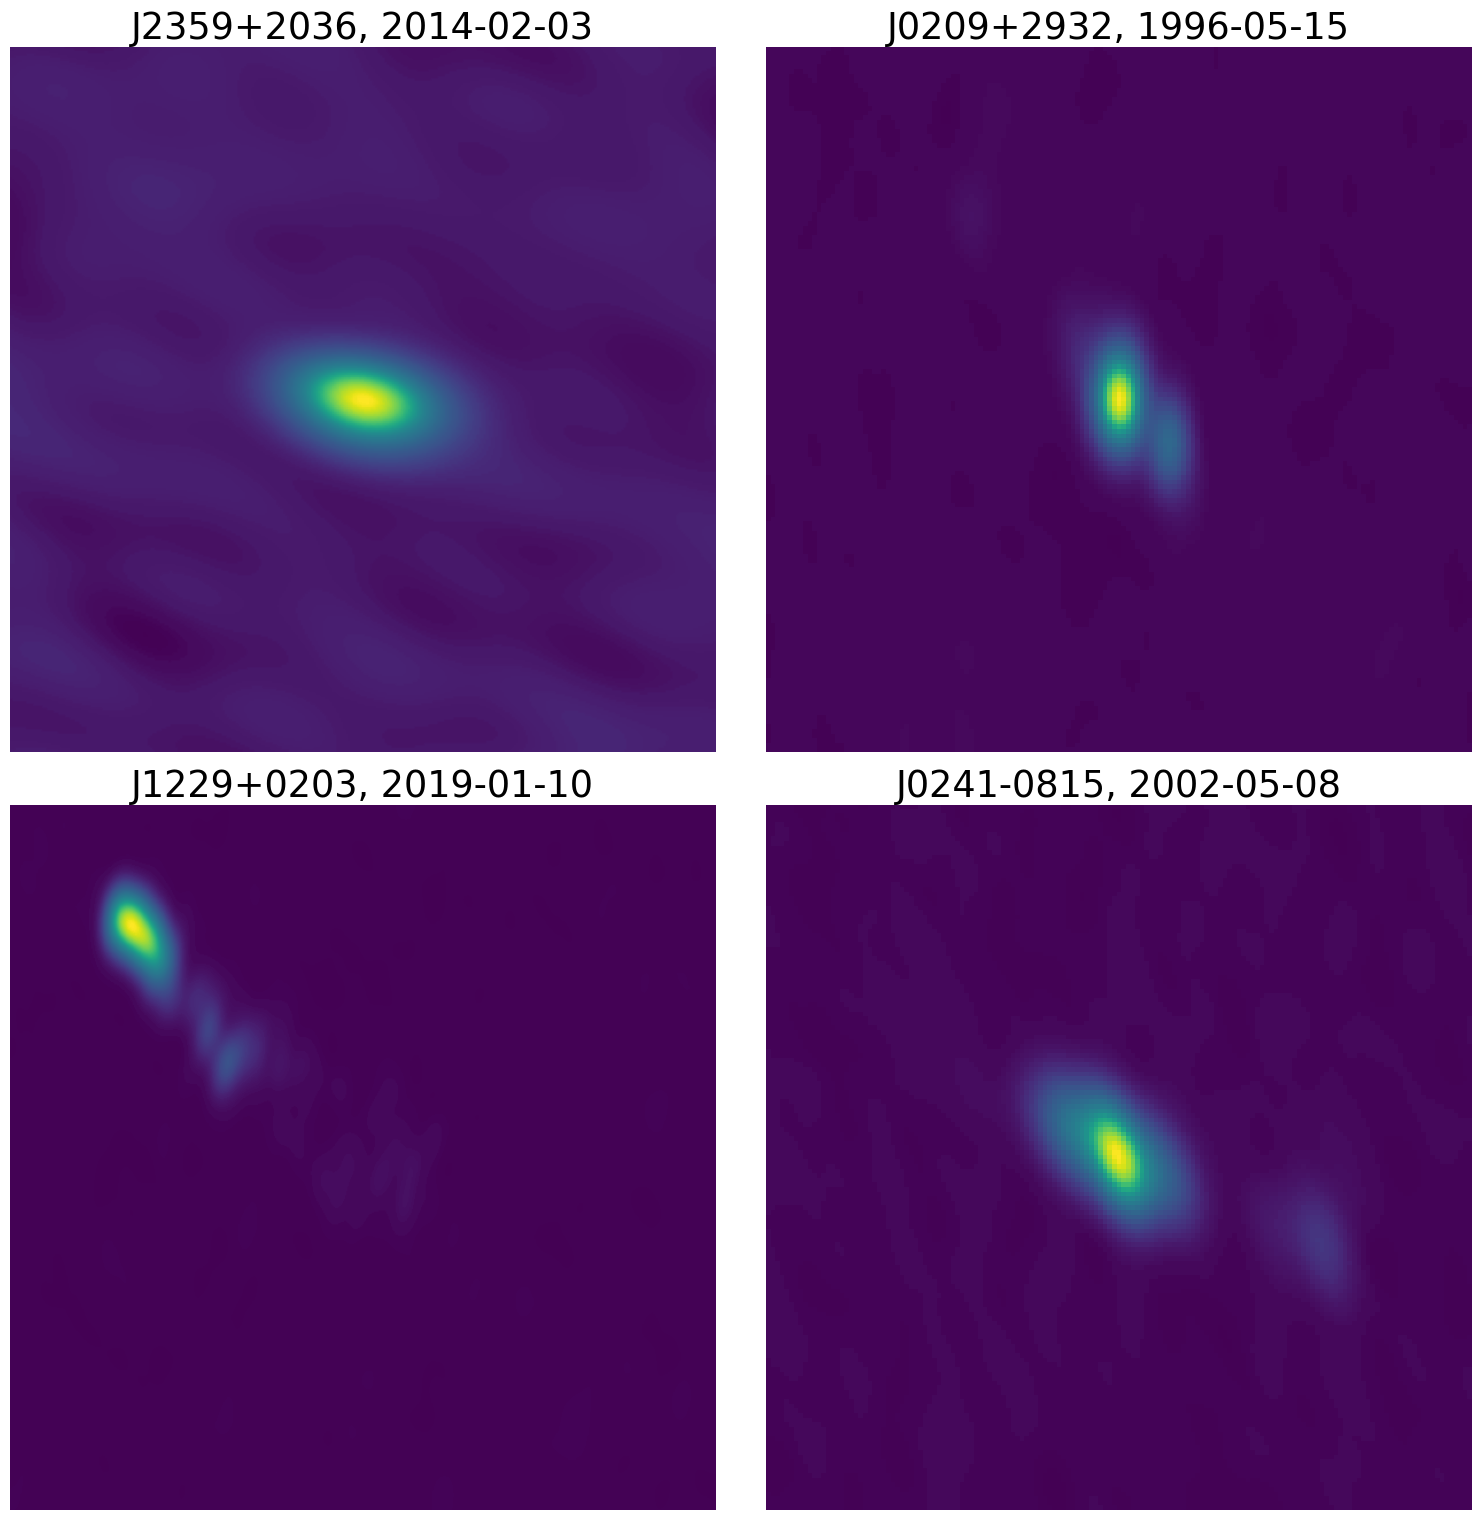

In [8]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
real_sources = [
    'J2359+2036_C_2014_02_03_pet_map.png', 'J0209+2932_S_1996_05_15_yyk_map.png',
    'J1229+0203_Q_2019_01_10_mar_map.png', 'J0241-0815_S_2002_05_08_pus_map.png'
]
for i, src in enumerate(real_sources):
    im = np.asarray(Image.open(f'{container_path}/{src}').convert('L'))
    obj_name = src.split('_')[0]
    date = '-'.join(src.split('_')[2:5])
    im = im[im.shape[0]//5:4 * im.shape[0]//5, im.shape[1]//5:4 * im.shape[1]//5]
    axes[i//2][i%2].imshow(im)
    axes[i//2][i%2].axis('off')
    axes[i//2][i%2].set_title(f'{obj_name}, {date}')
fig.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)


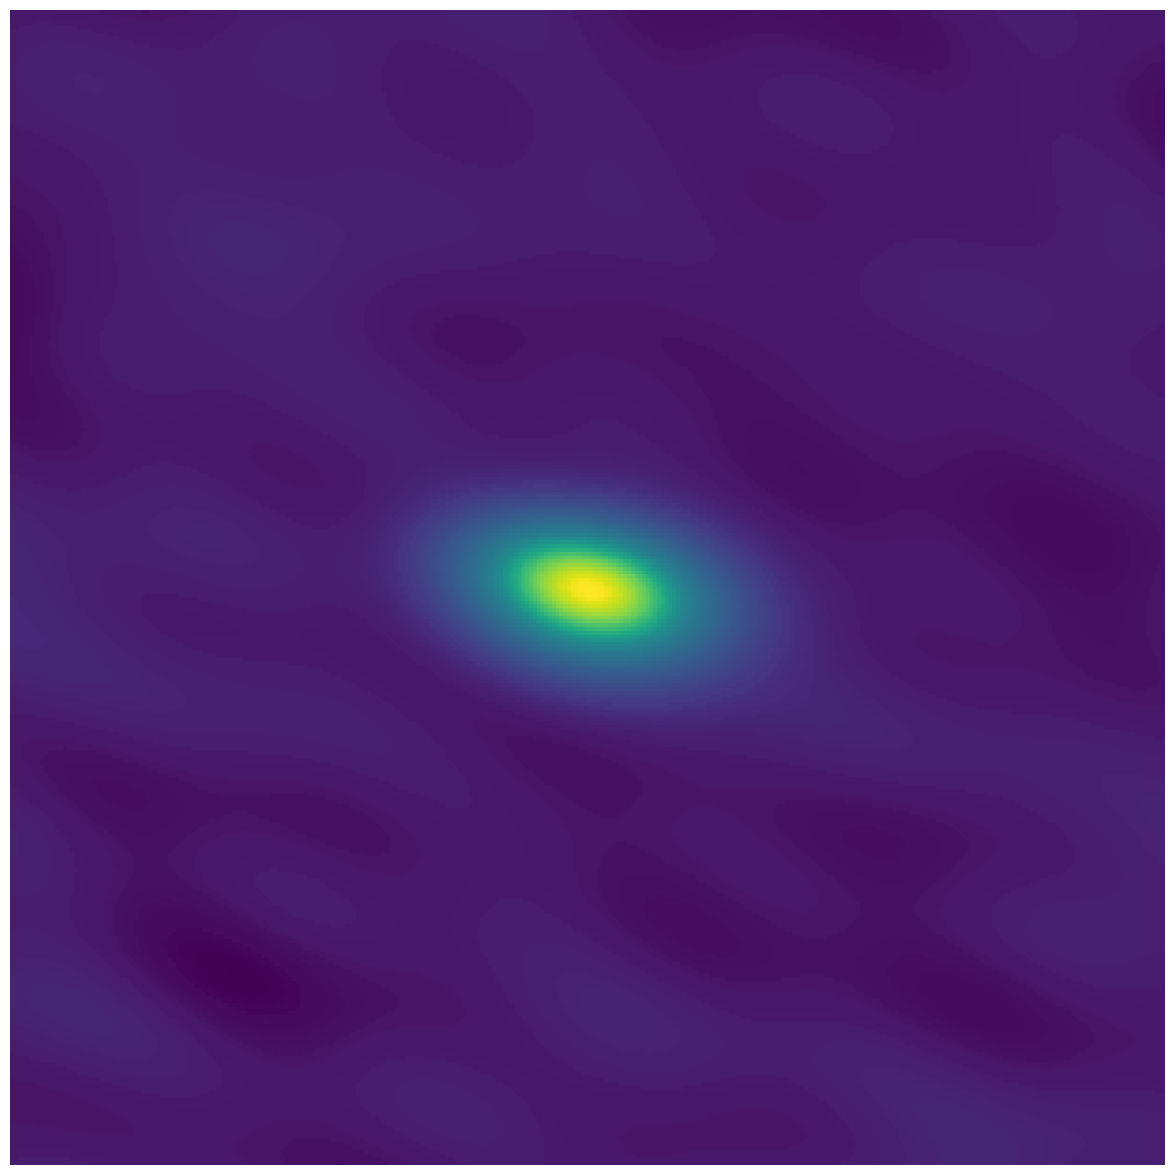

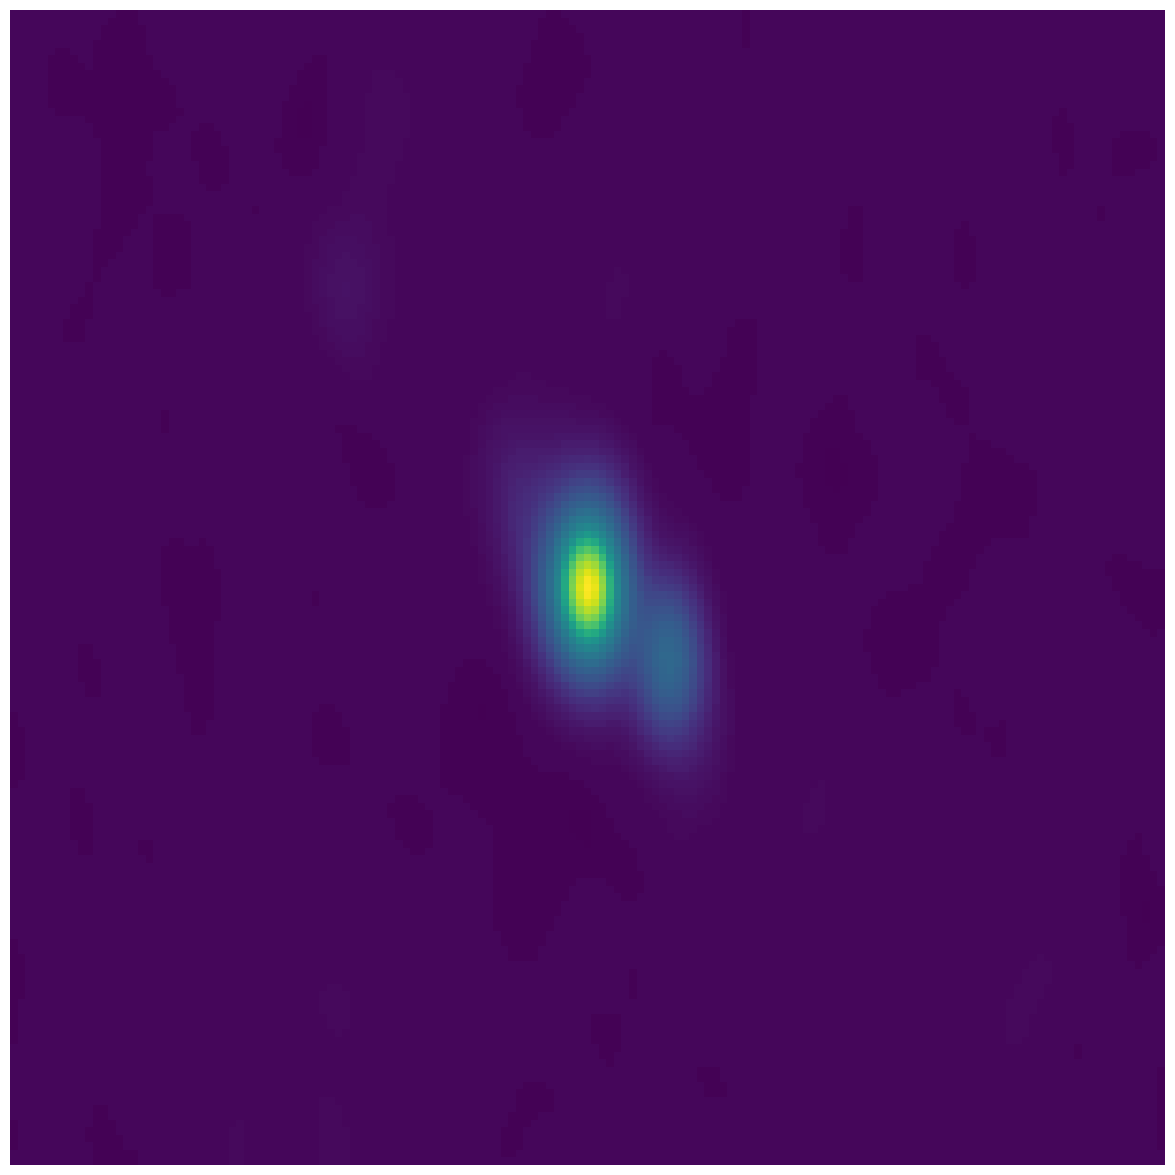

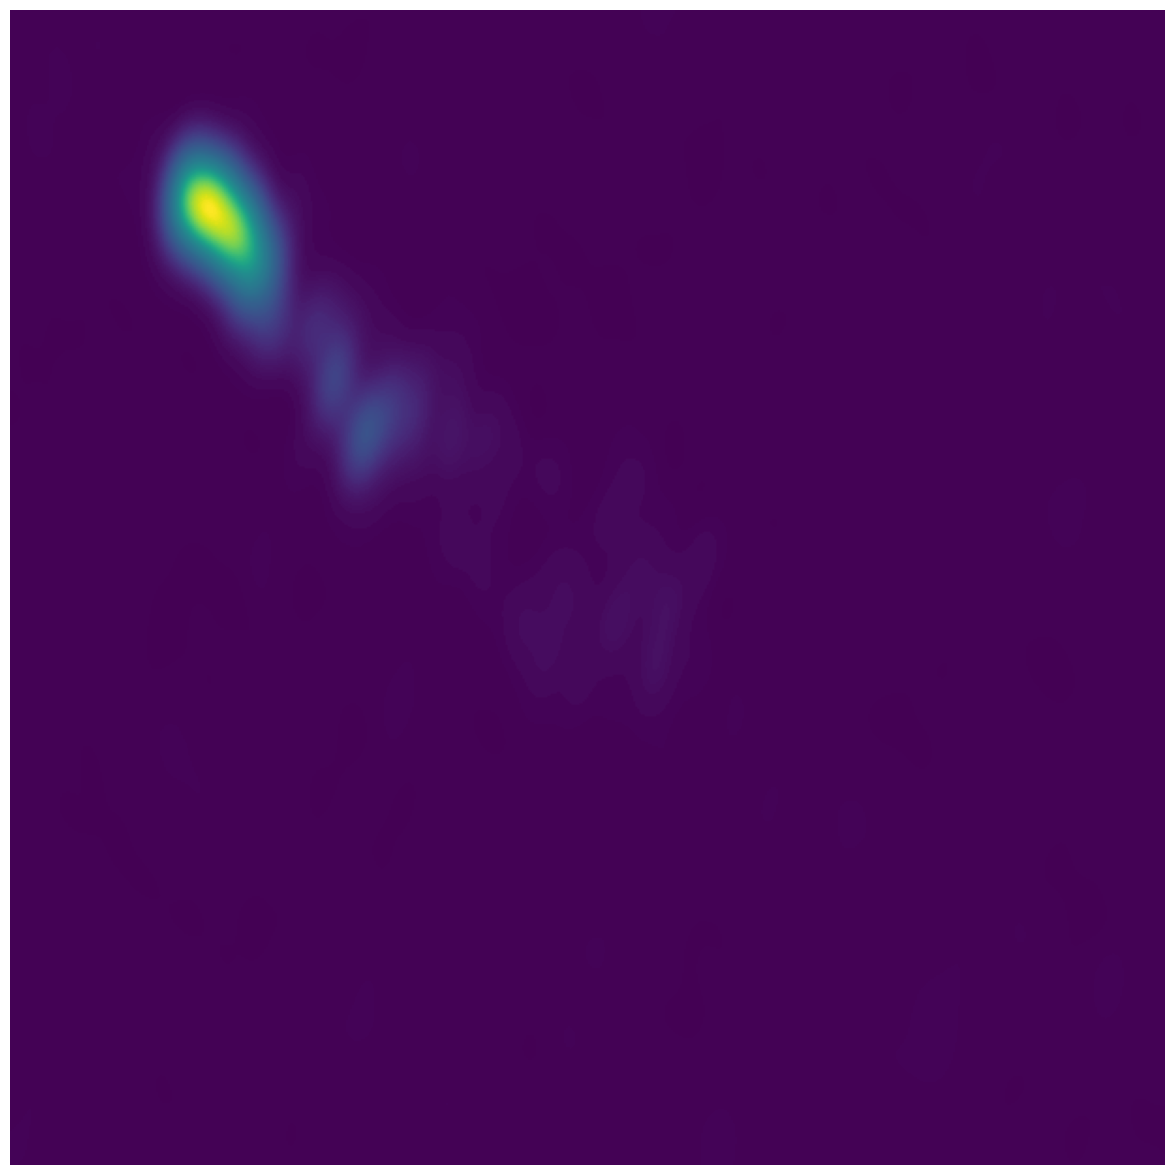

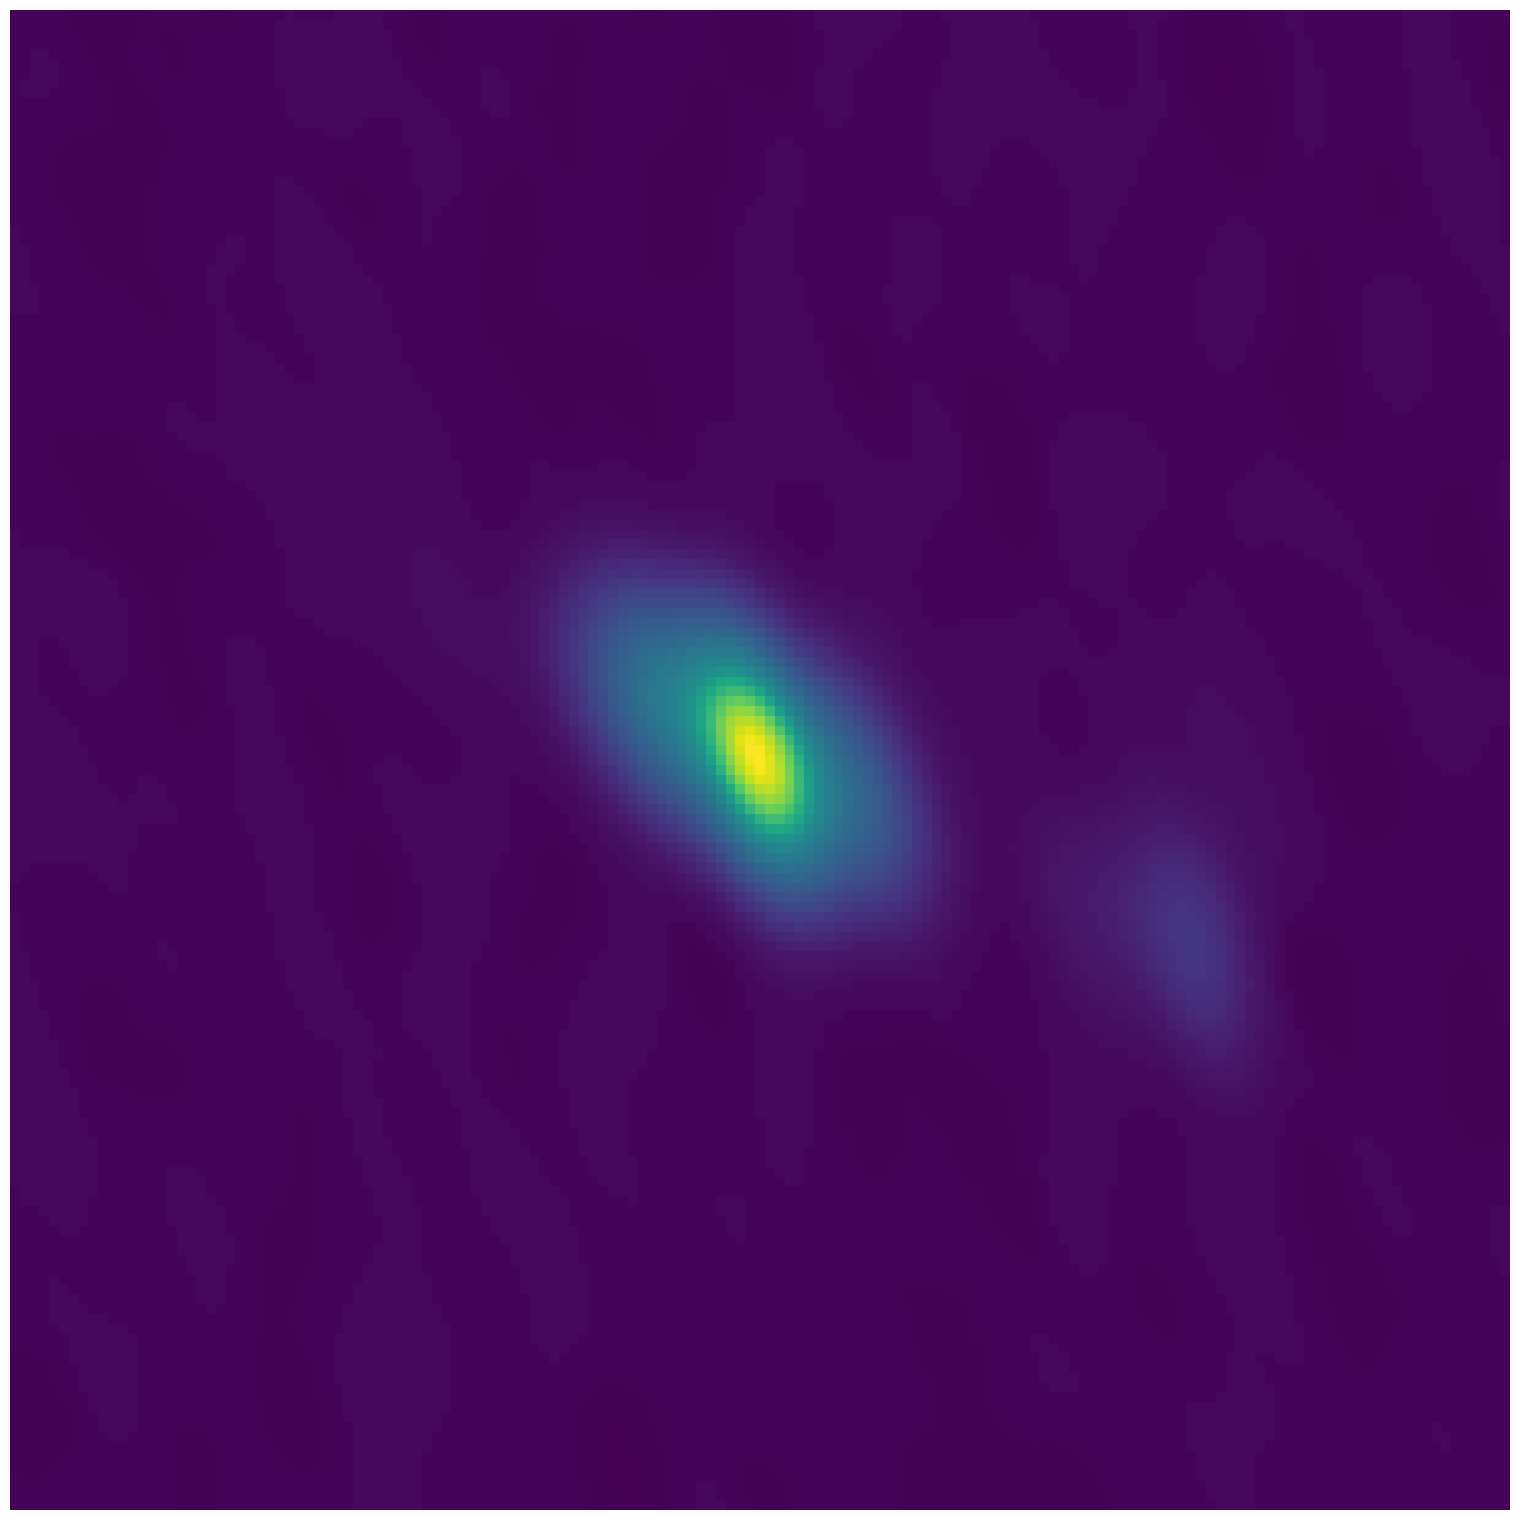

In [9]:
plt.rcParams.update({'font.size': 22})

real_sources = [
    'J2359+2036_C_2014_02_03_pet_map.png', 'J0209+2932_S_1996_05_15_yyk_map.png',
    'J1229+0203_Q_2019_01_10_mar_map.png', 'J0241-0815_S_2002_05_08_pus_map.png'
]
for i, src in enumerate(real_sources):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = np.asarray(Image.open(f'{container_path}/{src}').convert('L'))
    obj_name = src.split('_')[0]
    date = '-'.join(src.split('_')[2:5])
    im = im[im.shape[0]//5:4 * im.shape[0]//5, im.shape[1]//5:4 * im.shape[1]//5]
    ax.imshow(im)
    ax.axis('off')
    # ax.set_title(f'{obj_name}, {date}')
fig.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)